# Часть первая: перенос стиля при помощи pix2pix

In [1]:
!nvidia-smi

Tue Dec 15 21:15:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Подготовим окружение

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Подготовим данные

In [4]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
!tar -xf facades.tar.gz
!rm -rf facades.tar.gz

--2020-12-15 21:15:10--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  13.2MB/s    in 2.2s    

2020-12-15 21:15:13 (13.2 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [5]:
def data_loader(path, subfolder, transform, batch_size, shuffle=True):
    data = torchvision.datasets.ImageFolder(path, transform=transform)
    data.class_to_idx[subfolder]
    dataloader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle = shuffle)
    return dataloader

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_loader = data_loader('./facades', 'train', transform, 1, shuffle=True)

Генератор

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()


        self.add_module('encoder_0', nn.Sequential(nn.Conv2d(3, 64, kernel_size=4, stride=2,padding=1),
                                                   nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('encoder_1', nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                                                   nn.BatchNorm2d(128),
                                                   nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('encoder_2', nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                                                   nn.BatchNorm2d(256),
                                                   nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('encoder_3', nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
                                                   nn.BatchNorm2d(512),
                                                   nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('encoder_4', nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
                                                   nn.BatchNorm2d(512),
                                                   nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('encoder_5', nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
                                                   nn.BatchNorm2d(512),
                                                   nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('encoder_6', nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
                                                   nn.BatchNorm2d(512),
                                                   nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('encoder_7', nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
                                              nn.LeakyReLU(negative_slope=0.2)))
        
        self.add_module('decoder_1', nn.Sequential(nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
                                                   nn.BatchNorm2d(512),
                                                   nn.Dropout2d(),
                                                   nn.ReLU()))
        self.add_module('decoder_2', nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
                                                   nn.BatchNorm2d(512),
                                                   nn.Dropout2d(),
                                                   nn.ReLU()))
        self.add_module('decoder_3', nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
                                                   nn.BatchNorm2d(512),
                                                   nn.Dropout2d(),
                                                   nn.ReLU()))
        self.add_module('decoder_4', nn.Sequential(nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU()))
        self.add_module('decoder_5', nn.Sequential(nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1),
                                              nn.BatchNorm2d(256),
                                              nn.ReLU()))
        self.add_module('decoder_6', nn.Sequential(nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
                                              nn.BatchNorm2d(128),
                                              nn.ReLU()))
        self.add_module('decoder_7', nn.Sequential(nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
                                              nn.BatchNorm2d(64),
                                              nn.ReLU()))
        self.add_module('decoder_8',nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2,padding=1))
        self.add_module('tanh',nn.Tanh())

    def forward(self, in_0):

        in_1 = self._modules['encoder_0'](in_0)
        in_2 = self._modules['encoder_1'](in_1)
        in_3 = self._modules['encoder_2'](in_2)
        in_4 = self._modules['encoder_3'](in_3)
        in_5 = self._modules['encoder_4'](in_4)
        in_6 = self._modules['encoder_5'](in_5)
        in_7 = self._modules['encoder_6'](in_6)
        in_8 = self._modules['encoder_7'](in_7)

        dec_1 = self._modules['decoder_1'](in_8)
        dec_1 = torch.cat((dec_1, in_7), dim=1)
        dec_2 = self._modules['decoder_2'](dec_1)
        dec_2 = torch.cat((dec_2, in_6), dim=1)
        dec_3 = self._modules['decoder_3'](dec_2)
        dec_3 = torch.cat((dec_3,in_5),dim=1)
        dec_4 = self._modules['decoder_4'](dec_3)
        dec_4 = torch.cat((dec_4, in_4),dim=1)
        dec_5 = self._modules['decoder_5'](dec_4)
        dec_5 = torch.cat((dec_5,in_3),dim=1)
        dec_6 = self._modules['decoder_6'](dec_5)
        dec_6 = torch.cat((dec_6,in_2),dim=1)
        dec_7 = self._modules['decoder_7'](dec_6)
        dec_7 = torch.cat((dec_7,in_1),dim=1)
        dec_8 = self._modules['decoder_8'](dec_7)
        o = self._modules['tanh'](dec_8)

        return o

Дискриминатор

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.add_module('discriminator_0', nn.Sequential(nn.Conv2d(6,64,kernel_size=4, stride=2, padding=1),
                                                         nn.ReLU()))
        self.add_module('discriminator_1', nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                                                         nn.BatchNorm2d(128),
                                                         nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('discriminator_2', nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                                                         nn.BatchNorm2d(256),
                                                         nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('discriminator_3', nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
                                                         nn.BatchNorm2d(512),
                                                         nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('discriminator_4', nn.Sequential(nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),
                                                         nn.BatchNorm2d(1),
                                                         nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('sigmoid', nn.Sigmoid())

    def forward(self, in_0):

        in_1 = self._modules['discriminator_0'](in_0)
        in_2 = self._modules['discriminator_1'](in_1)
        in_3 = self._modules['discriminator_2'](in_2)
        in_4 = self._modules['discriminator_3'](in_3)
        in_5 = self._modules['discriminator_4'](in_4)
        x = self._modules['sigmoid'](in_5)

        return x

In [9]:
def train(dataloader, G, D, G_optimizer, D_optimizer, BCE_loss, L1_loss, num_epochs, device=torch.device("cpu")):
    G.train()
    D.train()
    D = D.to(device)
    G = G.to(device)
    BCE_loss = BCE_loss.to(device)
    L1_loss = L1_loss.to(device)

    for epoch in tqdm(range(num_epochs)):

        for x_, _ in dataloader:
            
            y_ = x_[:, :, :, 0:256]
            x_ = x_[:, :, :, 256:]
            
            x_ = Variable(x_.to(device))
            y_ = Variable(y_.to(device))

            G_optimizer.zero_grad()
            D_optimizer.zero_grad()
            fake = G.forward(x_)
            fake_x = torch.cat((fake, x_),dim=1)
            y_x = torch.cat((y_, x_),dim=1)
            pred_real = D.forward(y_x)
            pred_fake = D.forward(fake_x.detach())
            ones = torch.ones_like(pred_real)
            zeros = torch.zeros_like(pred_fake)

            loss_D = 0.5 * (BCE_loss(pred_real, ones) + BCE_loss(pred_fake, zeros))
            loss_D.backward(retain_graph=True)
            D_optimizer.step()

            L1_l = L1_loss(y_, fake)
            GAN_l = BCE_loss(pred_fake, ones)
            loss_G = L1_l

            loss_G.backward()
            G_optimizer.step()

Инициализация

In [10]:
generator = Generator()
discriminator = Discriminator()
BCE_loss = nn.BCELoss()
L1_loss = nn.L1Loss()
G_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

Обучение

In [11]:
train(train_loader, generator, discriminator, G_optimizer, D_optimizer, BCE_loss, L1_loss, num_epochs = 50, device=device)

100%|██████████| 50/50 [17:00<00:00, 20.42s/it]


In [12]:
torch.save(generator.state_dict(), 'generator_50ep.pth')

Проверка качества

In [15]:
test_loader = data_loader('./facades', 'test', transform, 1, shuffle=True)

test = test_loader.__iter__().__next__()[0]

x = test[:, :, :, 256:]
y = test[:, :, :, 0:256]

generator.eval()
pred = generator(x.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


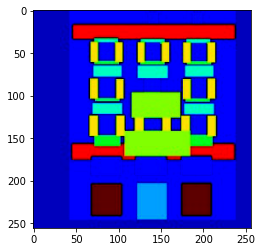

In [30]:
plt.imshow(x[0].permute(1,2,0).numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


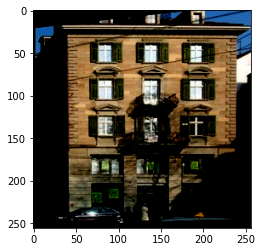

In [31]:
plt.imshow(y[0].permute(1,2,0).numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


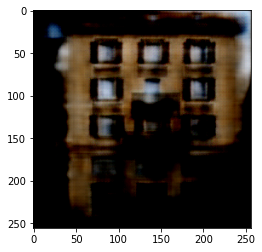

In [38]:
plt.imshow(pred.cpu()[0].permute(1,2,0).detach().numpy())
plt.show()

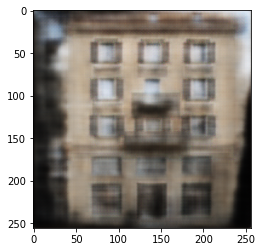

In [40]:
im = pred.cpu()[0].permute(1,2,0).detach().numpy()
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
example = std * im + mean
plt.imshow(example)
plt.show()

In [41]:
test = test_loader.__iter__().__next__()[0]

x = test[:, :, :, 256:]
y = test[:, :, :, 0:256]

generator.eval()
pred = generator(x.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


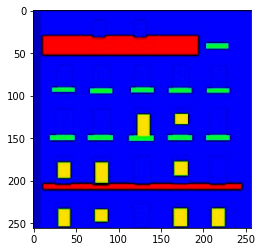

In [42]:
plt.imshow(x[0].permute(1,2,0).numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


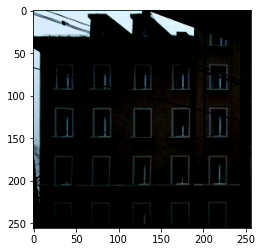

In [43]:
plt.imshow(y[0].permute(1,2,0).numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


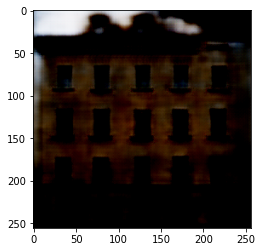

In [44]:
plt.imshow(pred.cpu()[0].permute(1,2,0).detach().numpy())
plt.show()

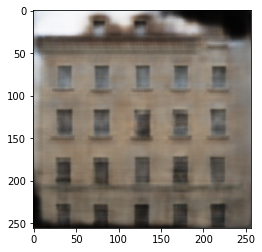

In [45]:
im = pred.cpu()[0].permute(1,2,0).detach().numpy()
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
example = std * im + mean
plt.imshow(example)
plt.show()